In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
VERSION = '07'

directory= f'../models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
        
class LossHistory(Callback):
    def __init__(self, number_of_epochs):
        self.number_of_epochs = number_of_epochs
        self.current_epoch = 0
    def on_train_begin(self, logs={}):
        self.initial_time = time.time()
    def on_batch_end(self, batch, logs={}):
        if logs['batch']==0:
            NUMBER_OF_DIESIS = 20
            self.current_epoch += 1
            progress = self.current_epoch/self.number_of_epochs
            diesis = np.round(progress*NUMBER_OF_DIESIS).astype('int')
            eta = (time.time()-self.initial_time) * (self.number_of_epochs/self.current_epoch -1)
            remaining_time = time.strftime("%H hours, %M min, %S sec", time.gmtime(eta))
            print('\r[{}{}] acc: {:.3f} eta: {}'.format('#'*diesis, '-'*(NUMBER_OF_DIESIS-diesis), logs['acc'], remaining_time), end='')

## Hyperparameters setting

In [4]:
def create_grid(params={}):
    if os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))
        test_index = grid_df['test_index'].max() + 1
    else:
        test_index = 0

    current_grid = {
        'version'                : ['str'     , VERSION],
        'params'                 : ['O'       , params],
        'test_index'             : [np.int    , test_index],
        
        # Load and preprocess
        'batch_size_data'        : [np.int    , 200],
        'x_std'                  : [np.float  , 3.398],
        'y_std'                  : [np.float  , 2.926],
        'sigma_cut'              : [np.float  , 0.1],
        
        # Metrics
        'dropout'                 : [np.float  , 0.],
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        
        # Random seeds
        'seed_skf'               : [np.int    , 0],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        
        # Model properties
        'input_shape'            : ['O'       , None],
        'LSTM_size'              : [np.int    , 256],
        'dropout'                : [np.float  , 0],
        
        # Training parameters
        'learning_rate'          : [np.float  , 2e-4],
        'batch_size'             : [np.int    , 32],
        'epochs'                 : [np.int    , 200],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        
        # Outputs
        'best_model_paths'       : ['O'       , []],
        'best_model_accuracies'  : ['O'       , []],
        'fit_outs'               : ['O'       , []]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

def add_grid_and_save(grid):
    if os.path.isfile('../model_data/grid_{}.pkl'.format(grid['version'][1])):
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    else:
        grid_df = pd.DataFrame()
        
    grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)        
    grid_df.to_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))

## Dataset loading and preprocessing

In [5]:
from sklearn.model_selection import train_test_split
def load_data(grid):
    right = pd.read_csv("../data/right.txt", header=None).values.tolist()
    left = pd.read_csv("../data/left.txt", header=None).values.tolist()
    
    BATCH_SIZE = grid['batch_size_data'][1]
    batch_right = [right[i:i + BATCH_SIZE] for i in range(0, len(right), BATCH_SIZE)]
    batch_left = [left[i:i + BATCH_SIZE] for i in range(0, len(left), BATCH_SIZE)]

    X_load = np.array(batch_right + batch_left)
    y_load = np.array([0]*len(batch_right) + [1]*len(batch_left))

    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=0.15, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

In [6]:
def pre_process_data(X, y, grid):
    # relative mouse movement
    X_diff = X[:,:-1,:].copy()
    X_diff[:,:,0] = np.diff(X[:,:,0])
    X_diff[:,:,1] = np.diff(X[:,:,1])
    
    # remove batches with no mouse activity
    sigma_x = np.std(X_diff[:,:,0], axis=1)
    sigma_y = np.std(X_diff[:,:,1], axis=1)
    mask = (sigma_x>grid['sigma_cut'][1])*(sigma_y>grid['sigma_cut'][1])

    X_filt = X_diff[mask]
    y_filt = y[mask]

    
    # normalize data
    x_std = grid['x_std'][1] # np.mean(np.std(X_filt[:,:,0], axis=1))
    y_std = grid['y_std'][1] # np.mean(np.std(X_filt[:,:,1], axis=1))

    X_filt[:,:,0] = X_filt[:,:,0] / x_std
    X_filt[:,:,1] = X_filt[:,:,1] / y_std
    
    return X_filt, y_filt

## Model definition

In [7]:
def create_model(grid):
    model = Sequential()
    model.add(LSTM(grid['LSTM_size'][1], input_shape=grid['input_shape'][1],
                   kernel_initializer=glorot_uniform(seed=grid['seed_model'][1]),
                  dropout=grid['dropout'][1]))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    return model

In [8]:
def train_model(X, y, model, grid):
    skf = StratifiedKFold(n_splits=grid['skf_n_splits'][1], shuffle=True, random_state=grid['seed_skf'][1])
    train_index, dev_index = list(skf.split(X, y))[len(grid['fit_outs'][1])]
    X_train, X_dev = X[train_index], X[dev_index]
    y_train, y_dev = y[train_index], y[dev_index]

    adam = Adam(lr=grid['learning_rate'][1])
    progress_bar = LossHistory(grid['epochs'][1])
    
    chk = ModelCheckpoint(grid['best_model_paths'][1][-1], monitor=grid['best_model_metric'][1],
                          save_best_only=True, mode='max', verbose=0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[grid['training_metric'][1]])
    fit_out = model.fit(X_train, y_train, epochs=grid['epochs'][1], batch_size=grid['batch_size'][1],
                        callbacks=[chk, progress_bar], validation_data=(X_dev, y_dev), verbose=0)

    fit_out.model = None
    grid['fit_outs'][1].append(fit_out)
    return grid

In [9]:
def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    np.random.seed(grid['seed_numpy'][1])
    tf.set_random_seed(grid['seed_tensorflow'][1])
    random.seed(grid['seed_random'][1])

    grid['input_shape'][1] = (X.shape[1], 2)
    
    
    accuracies = []
    for index_split in range(grid['skf_n_splits'][1]): # looping on uncompleted CV trainings
        model = create_model(grid)
        print(f"\nCV validation {index_split+1} of {grid['skf_n_splits'][1]}")
        best_model_path = '../models/{}/best_model_{}_{}.pkl'.format(grid['version'][1], grid['test_index'][1], index_split)
        grid['best_model_paths'][1].append(best_model_path)
        grid = train_model(X, y, model, grid)
        grid['best_model_accuracies'][1].append(np.max(grid['fit_outs'][1][-1].history['val_acc']))
    
    add_grid_and_save(grid)

    total_time = time.strftime("%H hours, %M min, %S sec", time.gmtime((time.time() - initial_time)))
    print('  --  Model trained in {}'.format(total_time))
    return grid

### Run training

In [10]:
grid = create_grid()

X_train, X_test, y_train, y_test = load_data(grid)
X_train, y_train = pre_process_data(X_train, y_train, grid)
X_test, y_test = pre_process_data(X_test, y_test, grid)

In [11]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def scale_params(point, actual_to_norm=True):
    params = point.copy()
    if actual_to_norm:
        params['LSTM_size'] = remap(float(params['LSTM_size']), 150, 300, 0, 1)
    else:
        params['LSTM_size'] = int(remap(params['LSTM_size'], 0, 1, 20, 250))
    return params


def test_params(next_point_to_probe):
    next_point_scaled = scale_params(next_point_to_probe, actual_to_norm=False)
    print(f'Testing {next_point_scaled}')
    grid = create_grid(next_point_scaled)
    grid = run_training(X_train, y_train, grid, verbose=True)
    return np.mean(grid['best_model_accuracies'][1])

In [12]:
def plot_optimization(optimizer, utility):
    def scale_array(xy):
        rescaled = np.ones(xy.shape)
        for index, point in enumerate(xy):
            norm_point = {'LSTM_size': point[0], 'dropout': point[1]}
            point = scale_params(norm_point, actual_to_norm=False)
            rescaled[index,:] = [point['LSTM_size'], point['dropout']]
        return rescaled

    optimizer.suggest(utility)

    x_grid = np.linspace(0, 1, 100)
    y_grid = np.linspace(0, 1, 100)
    xx, yy = np.meshgrid(x_grid, y_grid)
    XY = np.append(xx, yy).reshape(-1, 2, order='F')
    mean, sigma = optimizer._gp.predict(XY , return_std=True)
    max_point = scale_params(optimizer.max['params'], actual_to_norm=False)
    scaled_lims = scale_array(np.array([[0,0], [1,1]]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    for ax in (ax1, ax2):
        rescaled = scale_array(optimizer.space.params)
        ax.scatter(rescaled[:, 0], rescaled[:, 1], zorder=3, c=optimizer.space.target, cmap='inferno', marker='D')
        ax.scatter(max_point['LSTM_size'], max_point['dropout'], color='white', s=300, zorder=8, alpha=0.5)
        #ax.set_yscale('log')
        ax.set_xlim(scaled_lims[0, 0], scaled_lims[1, 0])
        ax.set_ylim(scaled_lims[0, 1], scaled_lims[1, 1])

    xy_grid = scale_array(np.array([x_grid, y_grid]).T)
    ax1.contourf(xy_grid[:,0], xy_grid[:,1], mean.reshape(xx.shape), 90, zorder=1)
    ax2.contourf(xy_grid[:,0], xy_grid[:,1], sigma.reshape(xx.shape), 90, zorder=1)
    ax1.set_title('Mean')
    ax2.set_title('Sigma')
    plt.show()

Testing {'LSTM_size': 168, 'dropout': 0.22844909378106992}

CV validation 1 of 5
[####################] acc: 0.438 eta: 00 hours, 00 min, 00 sec
CV validation 2 of 5
[####################] acc: 0.750 eta: 00 hours, 00 min, 00 sec
CV validation 3 of 5
[####################] acc: 0.844 eta: 00 hours, 00 min, 00 sec
CV validation 4 of 5
[####################] acc: 0.594 eta: 00 hours, 00 min, 00 sec
CV validation 5 of 5
[####################] acc: 0.594 eta: 00 hours, 00 min, 00 sec  --  Model trained in 00 hours, 39 min, 44 sec


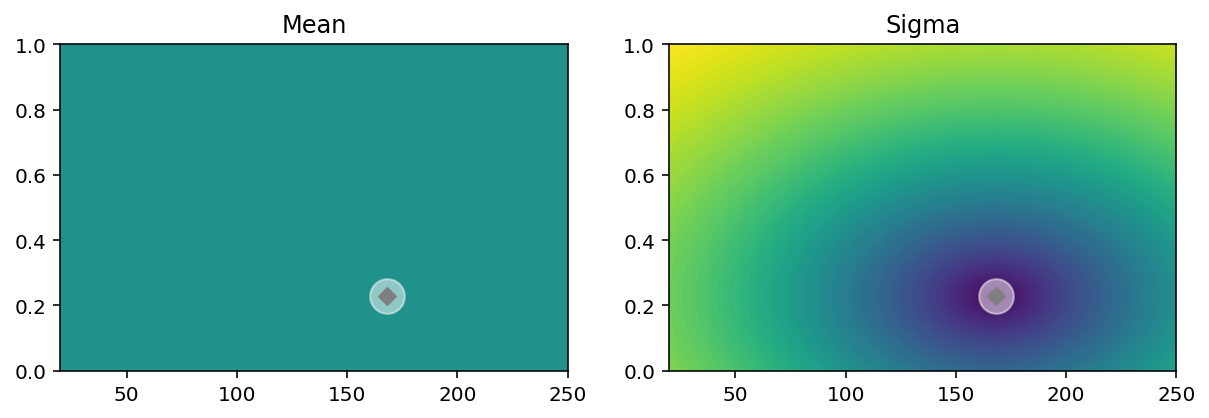

Testing {'LSTM_size': 20, 'dropout': 0.6}

CV validation 1 of 5
[####################] acc: 0.469 eta: 00 hours, 00 min, 00 sec
CV validation 2 of 5
[####################] acc: 0.562 eta: 00 hours, 00 min, 00 sec
CV validation 3 of 5
[####################] acc: 0.469 eta: 00 hours, 00 min, 00 sec
CV validation 4 of 5
[####################] acc: 0.344 eta: 00 hours, 00 min, 00 sec
CV validation 5 of 5
[####################] acc: 0.500 eta: 00 hours, 00 min, 00 sec  --  Model trained in 00 hours, 24 min, 51 sec


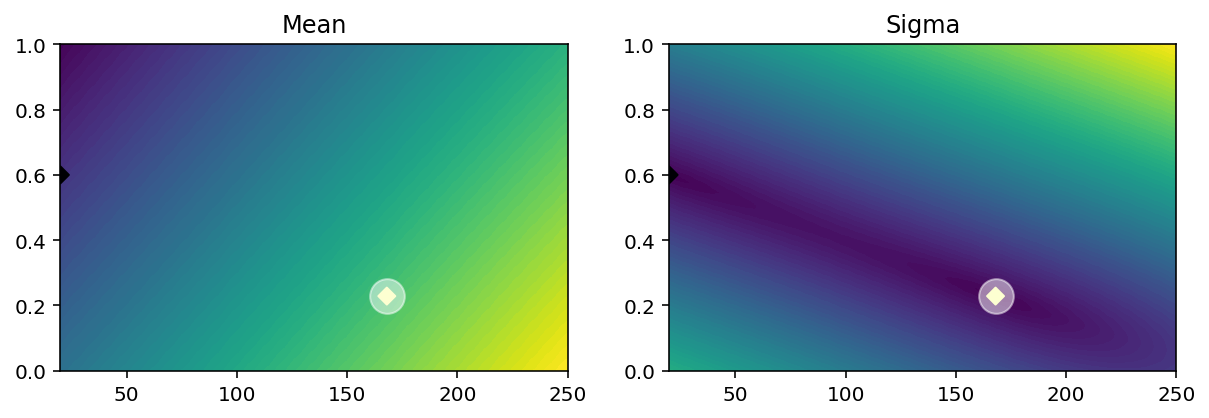

Testing {'LSTM_size': 250, 'dropout': 0.6}

CV validation 1 of 5
[####################] acc: 0.812 eta: 00 hours, 00 min, 00 sec
CV validation 2 of 5
[####################] acc: 0.719 eta: 00 hours, 00 min, 00 sec
CV validation 3 of 5
[####################] acc: 0.500 eta: 00 hours, 00 min, 00 sec
CV validation 4 of 5
[####################] acc: 0.750 eta: 00 hours, 00 min, 00 sec
CV validation 5 of 5
[####################] acc: 0.656 eta: 00 hours, 00 min, 00 sec  --  Model trained in 00 hours, 51 min, 44 sec


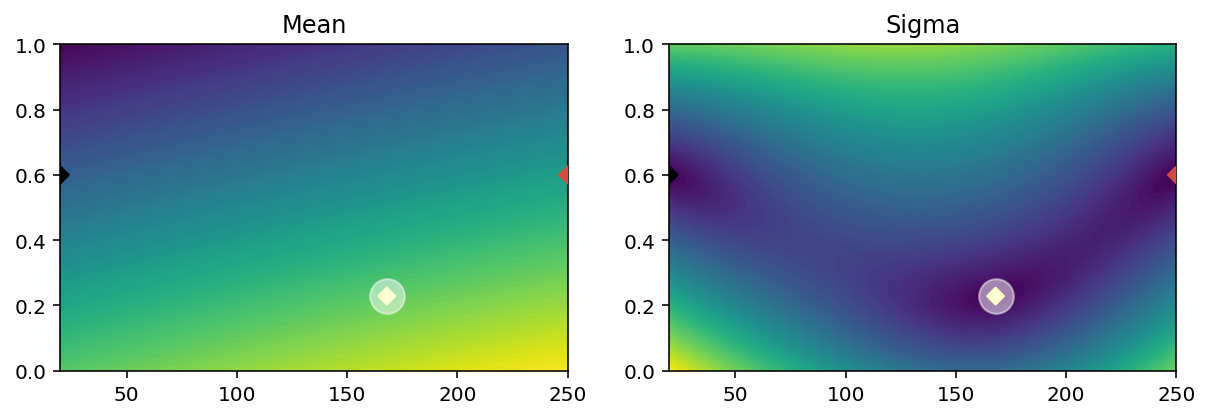

Testing {'LSTM_size': 250, 'dropout': 0.0}

CV validation 1 of 5
[####################] acc: 0.875 eta: 00 hours, 00 min, 00 sec
CV validation 2 of 5
[####################] acc: 0.625 eta: 00 hours, 00 min, 00 sec
CV validation 3 of 5
[####################] acc: 0.500 eta: 00 hours, 00 min, 00 sec
CV validation 4 of 5
[####################] acc: 0.688 eta: 00 hours, 00 min, 00 sec
CV validation 5 of 5
[####################] acc: 0.844 eta: 00 hours, 00 min, 00 sec  --  Model trained in 00 hours, 52 min, 17 sec


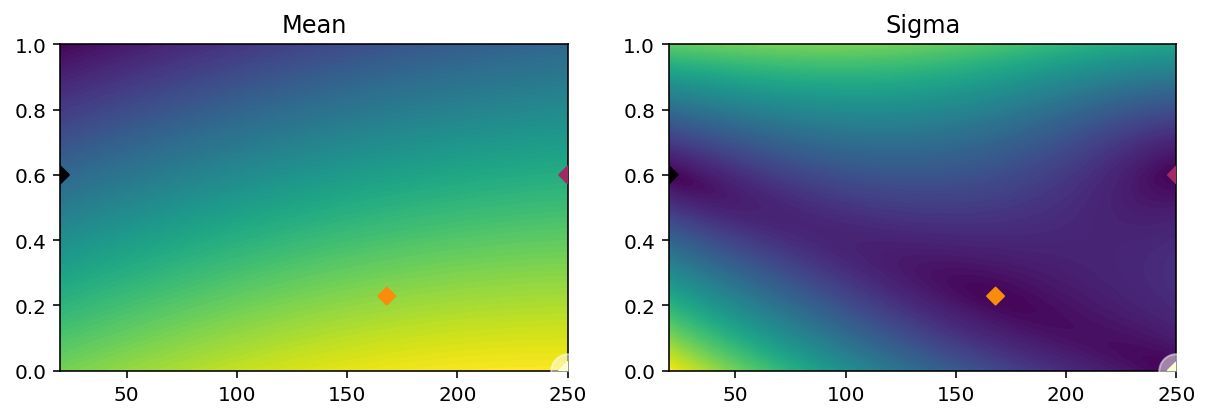

Testing {'LSTM_size': 200, 'dropout': 0.0}

CV validation 1 of 5
[#-------------------] acc: 0.531 eta: 00 hours, 15 min, 19 sec

KeyboardInterrupt: 

In [59]:
%%time

optimizer = BayesianOptimization(
    f=test_params,
    pbounds={'LSTM_size': (0, 1), 'dropout': (0, 0.6)},
    verbose=0,
    random_state=30)

utility = UtilityFunction(kind="ucb", kappa=1., xi=None)


## BAYESIAN SEARCH
if os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))

    for point, best_model_accuracies in zip(grid_df['params'], grid_df['best_model_accuracies']):
        
        point = scale_params(point, actual_to_norm=True)
        optimizer.register(params=point, target=np.mean(best_model_accuracies))
        
for _ in range(20):
    next_point_to_probe = optimizer.suggest(utility)
    target = test_params(next_point_to_probe)
    optimizer.register(params=next_point_to_probe, target=target)
    plot_optimization(optimizer, utility)

'#1f77b4'

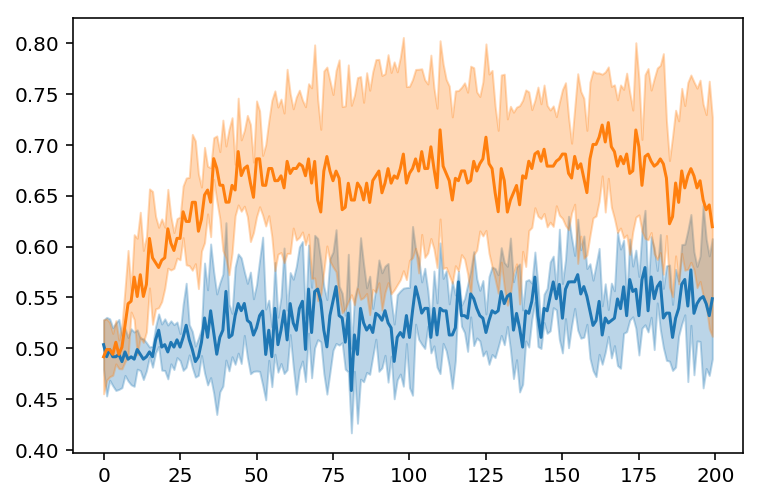

In [51]:
grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))


# for fo in grid_df.fit_outs:
#     somma = [x.history['acc'] for x in fo]
#     plt.plot(np.mean(somma, 0))
# plt.show()
for fo in grid_df.fit_outs[2:]:
    somma = [x.history['val_acc'] for x in fo]
    line, = plt.plot(np.mean(somma, 0))
    plt.fill_between(range(np.mean(somma, 0).shape[0]),np.mean(somma, 0)-np.std(somma, 0), np.mean(somma, 0)+np.std(somma, 0),
                    color=line.get_color(), alpha=0.3)

0.8588235315154581

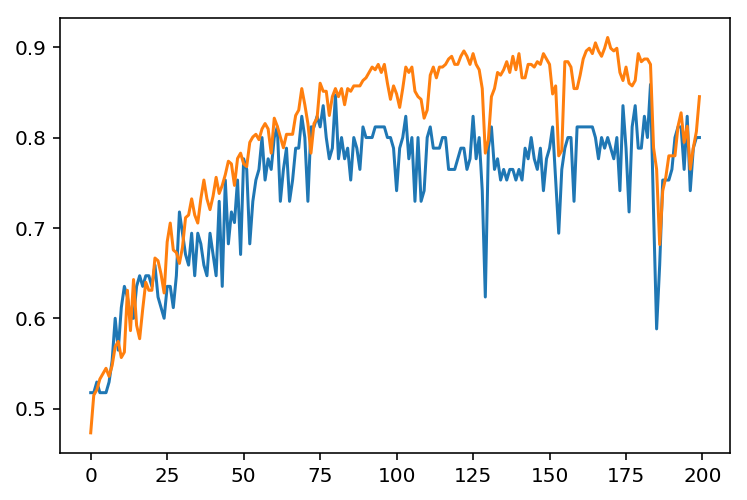

In [58]:
i=0
run = 3
plt.plot(grid_df.loc[run].fit_outs[i].history['val_acc'])
plt.plot(grid_df.loc[run].fit_outs[i].history['acc'])
grid_df.loc[run].best_model_accuracies[i]

In [62]:
grid_df.loc[3].params

{'LSTM_size': 250, 'dropout': 0.0}

In [68]:
grid_df.droput

0    0.0
1    0.0
2    0.0
3    0.0
Name: droput, dtype: float64

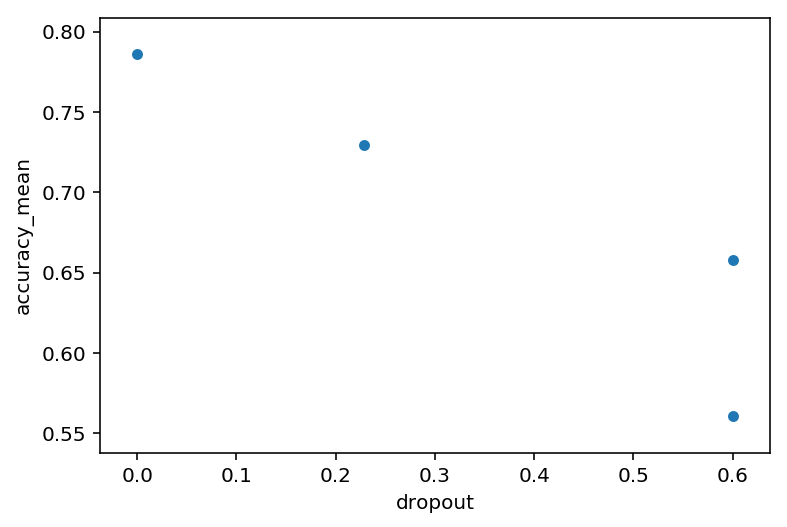

In [69]:
grid_df.plot('dropout','accuracy_mean', kind='scatter')

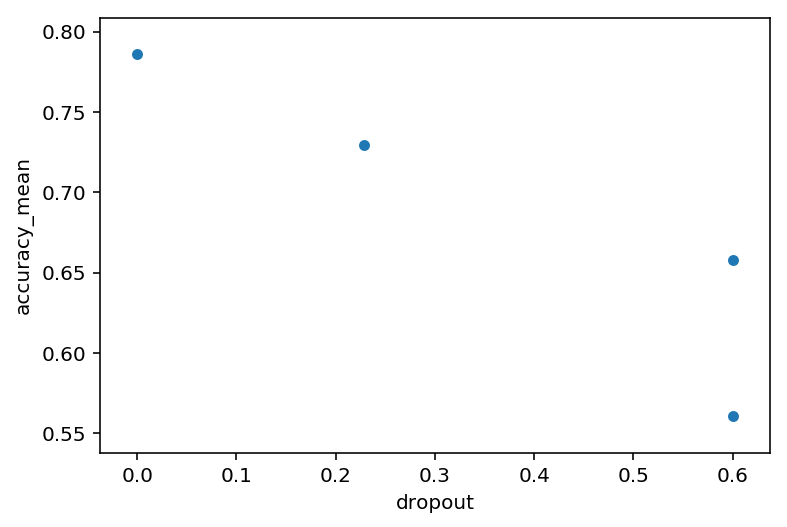

In [70]:
grid_df.plot('dropout','accuracy_mean', kind='scatter')

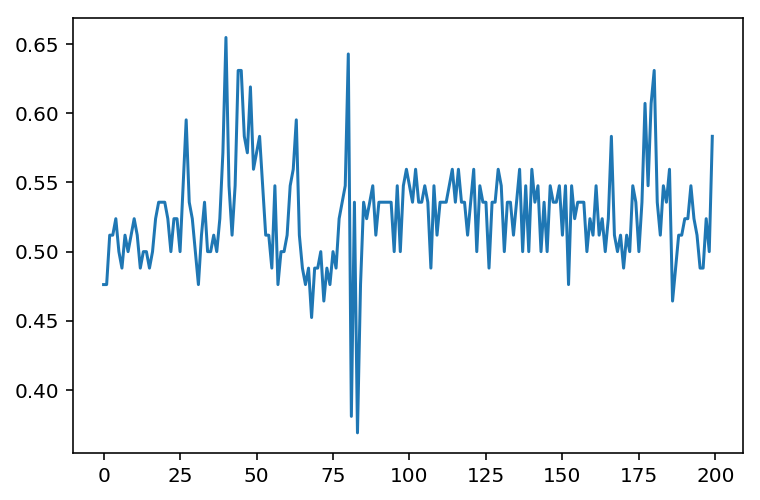

In [72]:
plt.plot(grid_df.fit_outs[2][4].history['val_acc'])

In [24]:
grid_df['accuracy_mean'] = grid_df['best_model_accuracies'].apply(np.mean)
model_path = (grid_df
              .query('LSTM_size> 200') 
              .sort_values(['accuracy_mean'], ascending = False)
              .iloc[0]['best_model_paths'][4])
best_model = load_model(model_path)

In [25]:
test_preds = best_model.predict_classes(X_test)
acc_test = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set: {acc_test*100:.1f}%')

Accuracy on the test set: 66.7%


In [81]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
# cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_test.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{VERSION}.png', bbox_inches='tight')

NameError: name 'y_test' is not defined

In [26]:
grid_df.plot('LSTM_size', 'best_model_accuracy', kind='scatter')

KeyError: 'best_model_accuracy'

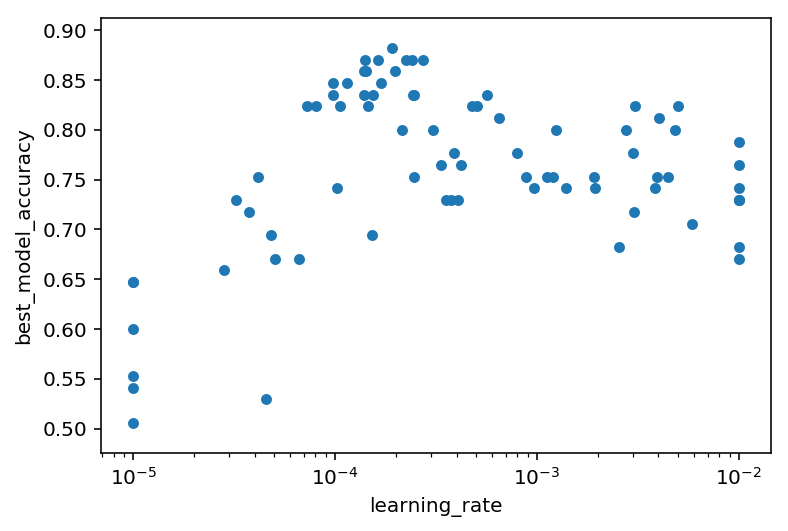

In [31]:
grid_df.plot('learning_rate', 'best_model_accuracy', kind='scatter', logx=True)

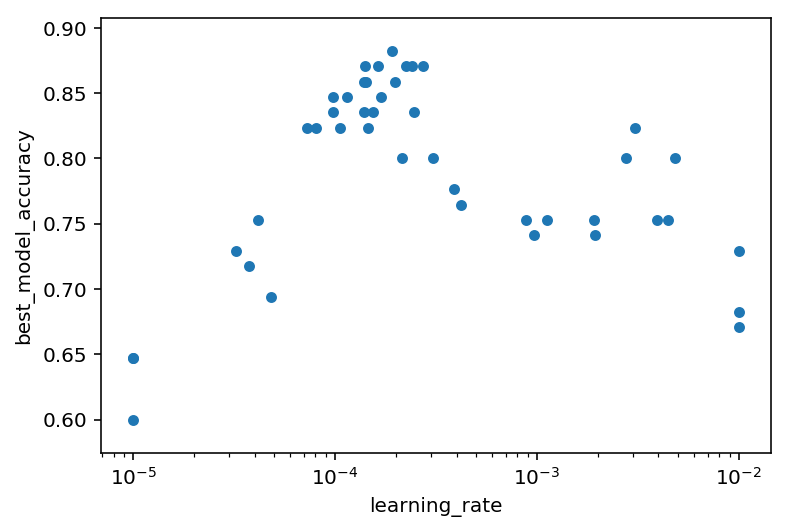

In [33]:
(grid_df
    .query('LSTM_size > 150')
    .plot('learning_rate', 'best_model_accuracy', kind='scatter', logx=True)
)

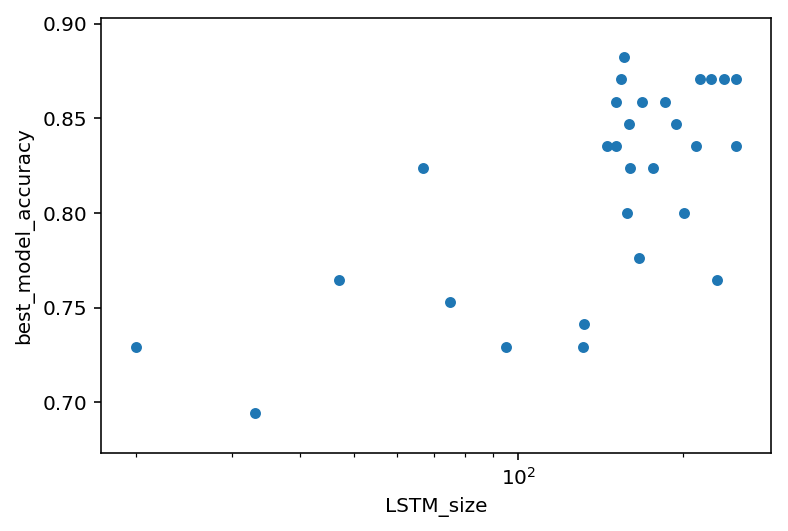

In [36]:
(grid_df
    .query('learning_rate > 1e-4 & learning_rate < 5e-4')
    .plot('LSTM_size', 'best_model_accuracy', kind='scatter', logx=True)
)

In [39]:
(grid_df
    .query('LSTM_size> 200') 
    .sort_values(['best_model_accuracy'], ascending = False)
)

,LSTM_size,batch_size,batch_size_data,best_model_accuracy,best_model_metric,best_model_path,epochs,fit_out,index,input_shape,...,seed_sklearn,seed_tensorflow,sigma_cut,skf_n_splits,skf_split,test_size,training_metric,version,x_std,y_std
22,215,32,200,0.870588,val_acc,../models/06/best_model_105.pkl,200,<keras.callbacks.History object at 0x000001BFE...,105,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
43,237,32,200,0.870588,val_acc,../models/06/best_model_250.pkl,200,<keras.callbacks.History object at 0x000001BFE...,250,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
51,225,32,200,0.870588,val_acc,../models/06/best_model_258.pkl,200,<keras.callbacks.History object at 0x000001BFE...,258,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
48,250,32,200,0.870588,val_acc,../models/06/best_model_255.pkl,200,<keras.callbacks.History object at 0x000001BFE...,255,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
28,211,32,200,0.835294,val_acc,../models/06/best_model_111.pkl,200,<keras.callbacks.History object at 0x000001BFE...,111,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
63,233,32,200,0.835294,val_acc,../models/06/best_model_536.pkl,200,<keras.callbacks.History object at 0x000001BFE...,536,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
10,250,32,200,0.835294,val_acc,../models/06/best_model_20.pkl,200,<keras.callbacks.History object at 0x000001BFE...,20,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
37,250,32,200,0.823529,val_acc,../models/06/best_model_120.pkl,200,<keras.callbacks.History object at 0x000001BFE...,120,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
17,250,32,200,0.823529,val_acc,../models/06/best_model_48.pkl,200,<keras.callbacks.History object at 0x000001BFE...,48,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926
12,207,32,200,0.823529,val_acc,../models/06/best_model_43.pkl,200,<keras.callbacks.History object at 0x000001BFE...,43,"(199, 2)",...,0,0,0.1,5,0,0.15,accuracy,06,3.398,2.926


78